In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')

# 1 - Análise Exploratória de Dados

## 1.1 Primeira olhada

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Há valores faltantes em algumas variáveis, isso deve ser tratado. Primeiramente tentarei descobrir a importância de cada variável independente, a fim de definir como tratar essas variável com valores faltantes.

- Embarked: Vamos verificar se o porto de embarque possui relação com a probabilidade de sobrevivência. Intuitivamente podemos supor que não tem porém vamos averiguar essa suposição.

<AxesSubplot:xlabel='Embarked'>

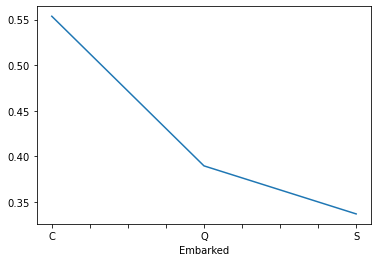

In [5]:
df.groupby(by=['Embarked'])['Survived'].mean().plot()

Parece haver relação do porto de embarque a probabiliade de sobrevivência, porém essa diferença pode não ser significativa ou essa variável ser proxy para outra. Precisaremos estudar mais para frente, porém como há apenas dois valores faltantes a princípio a deixarei na base de dados.

- Cabin: Como há muitos valores faltantes nessa variável e é do tipo texto, deixarei de fora do primeiro protótipo

- Age: A princípio a deixarei na base de dados, pois intuitivamente parece ser importante e não tem uma quantidade exorbitante de valores faltantes. 

## 1.2 - Separando conjunto de treinamento e de teste

Antes de mais nada separarei o conjunto de teste e de treinamento. Trabalharei apenas com o de treinamento a partir de agora a fim de não introduzir nenhum viés de amostragem.

### Separando de maneira estratificada

Já era sabido que o gênero do indivíduo é o que mais influência em sua probabiliade de sobrevivência.

In [6]:
df.groupby(by='Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Como é uma variável muito importante e a base de dados é muito pequena, utilizar uma amostragem probabilística aleatória não é uma boa ideia, pois é possível que o conjunto de teste não seja representativo. Utilizarei uma amostragem estratificada por sexo para garantir a representatividade dos dados.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [9]:
for train_i, test_i in strat.split(df, df['Sex']):
    strat_train = df.iloc[train_i]
    strat_test = df.iloc[test_i]

In [10]:
df.value_counts(['Sex'])/len(df)

Sex   
male      0.647587
female    0.352413
dtype: float64

In [11]:
strat_train.value_counts(['Sex'])/len(strat_train)

Sex   
male      0.647472
female    0.352528
dtype: float64

In [12]:
strat_test.value_counts(['Sex'])/len(strat_test)

Sex   
male      0.648045
female    0.351955
dtype: float64

Como pode ser observado, a amostragem estratificada garantiu que os conjuntos separados possuam a mesma proporção de homens e mulheres que a base de dados original.

## 1.3 Tratando os dados

Criarei uma copia do banco de dados de treinameto para poder explorá-lo e criar um pipeline de transformação de dados.

In [178]:
strain = strat_train.copy()

## 1.3.1 Excluindo colunas desnecessárias

As colunas 'Name', 'Ticket', e 'Cabin' aparentemente são desnecessárias para fazer as previsões. Porém há uma relação muito interessante, muitas pessoas com o mesmo sobrenome tinham o mesmo ticket e estavam na mesma cabine. Ou seja, muitos familiares viajando junto. Talvez em um protótipo mais complexo tal relação possa ser utilizada para realizar previsões.

In [179]:
strain[strain['Ticket'].duplicated(keep=False)].sort_values('Ticket').head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.00,0,0,110152,86.5000,B77,S
257,258,1,1,"Cherry, Miss. Gladys",female,30.00,0,0,110152,86.5000,B77,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.00,1,1,110413,79.6500,E67,S
262,263,0,1,"Taussig, Mr. Emil",male,52.00,1,1,110413,79.6500,E67,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.00,0,2,110413,79.6500,E68,S
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.00,0,1,111361,57.9792,B18,C
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.00,0,1,111361,57.9792,B18,C
61,62,1,1,"Icard, Miss. Amelie",female,38.00,0,0,113572,80.0000,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.00,1,2,113760,120.0000,B96 B98,S


Porém para esse protótipo mais simples excluirei as colunas 'Name', 'Cabin' e 'Ticket'

In [180]:
strain = strain.drop(['Name', 'Ticket', 'Cabin'], axis=1)

Colocarei o Id do Passageiro como índice e excluirei essa coluna

In [181]:
strain = strain.set_index('PassengerId')

## 1.3.2 Lidando com dados ausentes

In [182]:
strain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 789 to 262
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       578 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  710 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


Utilizarei a abordagem de imputar dados

In [183]:
from sklearn.impute import SimpleImputer

- Embarked: No caso de Embarked como é uma variável categórica e há poucos valores faltantes, substituirei pelo mais frequente

In [184]:
simp = SimpleImputer(strategy='most_frequent')

In [185]:
strain['Embarked'] = simp.fit_transform(strain[['Embarked']])

In [186]:
strain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 789 to 262
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       578 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


- Age: Substituirei pela média de idade agrupada por Sexo e Parch

In [187]:
def subs_medi(df):
    dat = SimpleImputer(strategy='mean')
    df['Age'] = dat.fit_transform(df[['Age']])
    return df

In [188]:
strain = strain.groupby(by=['Sex', 'Pclass']).apply(subs_medi)

# 1.3.3 Agrupando todas as funções em uma classe Sckit-Learn

Agruparei todos as funções de tratamento de dados em uma classe Sckit-Learn para ficar fácil implementar em um pipeline

In [191]:
from sklearn.base import BaseEstimator, TransformerMixin

In [434]:
class Tratar_Dados(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        def subs_medi(df):
            dat = SimpleImputer(strategy='mean')
            df['Age'] = dat.fit_transform(df[['Age']])
            return df
        df = X.drop(['Name', 'Ticket', 'Cabin'], axis=1)
        df = df.set_index('PassengerId')
        simp = SimpleImputer(strategy='most_frequent')
        df['Embarked'] = simp.fit_transform(df[['Embarked']])
        df = df.groupby(by=['Sex', 'Pclass']).apply(subs_medi)
        return df
        

In [260]:
strain

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
789,1,3,0,1.000000,1,2,20.5750,S
348,1,3,1,20.722222,1,0,16.1000,S
630,0,3,0,26.285346,0,0,7.7333,Q
735,0,2,0,23.000000,0,0,13.0000,S
107,1,3,1,21.000000,0,0,7.6500,S
...,...,...,...,...,...,...,...,...
264,0,1,0,40.000000,0,0,0.0000,S
629,0,3,0,26.000000,0,0,7.8958,S
712,0,1,0,41.675227,0,0,26.5500,S


## 1.4 Feature Engineering

Sexo receberá um 1 se for mulher e 0 se for homem

In [263]:
strain

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
789,1,3,0,1.000000,1,2,20.5750,S
348,1,3,1,20.722222,1,0,16.1000,S
630,0,3,0,26.285346,0,0,7.7333,Q
735,0,2,0,23.000000,0,0,13.0000,S
107,1,3,1,21.000000,0,0,7.6500,S
...,...,...,...,...,...,...,...,...
264,0,1,0,40.000000,0,0,0.0000,S
629,0,3,0,26.000000,0,0,7.8958,S
712,0,1,0,41.675227,0,0,26.5500,S


In [209]:
strain['Sex'] = (strain['Sex'] == 'female')*1

In [248]:
strain.corr(method='kendall')['Survived'][1:].sort_values(ascending=False)

Sex       0.550827
Fare      0.257084
Parch     0.123739
SibSp     0.069682
Age      -0.038476
Pclass   -0.302240
Name: Survived, dtype: float64

In [250]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [252]:
one_enc = OneHotEncoder()

In [255]:
emb_cat = one_enc.fit_transform(strain[['Embarked']])

In [261]:
ord_enc = OrdinalEncoder()

In [281]:
from sklearn.preprocessing import StandardScaler

In [264]:
from sklearn.compose import ColumnTransformer

In [310]:
full_pipeline = ColumnTransformer([
    ('ord', OrdinalEncoder(), ['Pclass', 'Sex', 'SibSp', 'Parch']),
    ('one', OneHotEncoder(), ['Embarked']),
    ('num', StandardScaler(), ['Age', 'Fare'])
])

In [328]:
class Pipe_Geral(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = Tratar_Dados().fit_transform(X)
        full_pipeline = ColumnTransformer([
    ('ord', OrdinalEncoder(), ['Pclass', 'Sex', 'SibSp', 'Parch']),
    ('one', OneHotEncoder(), ['Embarked']),
    ('num', StandardScaler(), ['Age', 'Fare'])
    ])
        return full_pipeline.fit_transform(df)

# 2 - Testando modelos para os dados

## 2.1 - Regressão Logística

In [330]:
strat_trat = Pipe_Geral().fit_transform(strat_train)

In [332]:
labels = strat_train['Survived']

In [335]:
from sklearn.linear_model import LogisticRegression

In [337]:
logr = LogisticRegression()

In [338]:
logr.fit(strat_trat, labels)

LogisticRegression()

In [339]:
pred = logr.predict(strat_trat)

In [341]:
from sklearn.metrics import accuracy_score

In [345]:
accuracy_score(labels, pred)

0.8571428571428571

## 2.1.1 Validação Cruzada

In [353]:
from sklearn.model_selection import cross_val_score

In [360]:
scores_logr = cross_val_score(logr, strat_trat, labels, scoring='accuracy', cv=10)

In [361]:
scores_logr

array([0.88888889, 0.73611111, 0.83098592, 0.77464789, 0.83098592,
       0.78873239, 0.8028169 , 0.77464789, 0.83098592, 0.83098592])

In [374]:
np.mean(scores_logr)

0.8089788732394366

## 2.2 - Árvore de Decisão

In [357]:
from sklearn.tree import DecisionTreeClassifier

In [358]:
tree = DecisionTreeClassifier()

In [ ]:
tree.fit(strat_train, labels)

In [362]:
scores_tree = cross_val_score(tree, strat_trat, labels, scoring='accuracy', cv=10)

In [363]:
scores_tree

array([0.72222222, 0.79166667, 0.8028169 , 0.78873239, 0.76056338,
       0.77464789, 0.77464789, 0.8028169 , 0.73239437, 0.78873239])

In [375]:
np.mean(scores_tree)

0.7739241001564945

## 2.3 - Floresta Aleatória

In [364]:
from sklearn.ensemble import RandomForestClassifier

In [368]:
rforest = RandomForestClassifier()

In [369]:
rforest.fit(strat_trat, labels)

RandomForestClassifier()

In [370]:
scores_rforest = cross_val_score(rforest, strat_trat, labels, scoring='accuracy', cv=10)

In [371]:
scores_rforest

array([0.86111111, 0.77777778, 0.81690141, 0.74647887, 0.76056338,
       0.85915493, 0.84507042, 0.85915493, 0.8028169 , 0.77464789])

In [373]:
np.mean(scores_rforest)

0.8103677621283255

In [385]:
pd.Series(rforest.feature_importances_, index=['Pclass','Sex', 'Age','SibSp','Parch','Fare','Embarked_1','Embarked_2','Embarked_3'])

Pclass        0.075258
Sex           0.264887
Age           0.054256
SibSp         0.041178
Parch         0.013163
Fare          0.010500
Embarked_1    0.014999
Embarked_2    0.262786
Embarked_3    0.262975
dtype: float64

# 3 - Testando modelo para conjunto de testes

In [390]:
lab_test = strat_test['Survived']

In [391]:
pred_test = rforest.predict(Pipe_Geral().fit_transform(strat_test))

In [396]:
accuracy_score(lab_test, pred_test)

0.8212290502793296

In [418]:
accuracy_score(lab_test, (strat_test['Sex']=='female'))

0.776536312849162

# 4 - Salvando o modelo de floresta aleatória

In [419]:
import joblib

In [420]:
joblib.dump(rforest, 'prototipo_floresta_aleatoria.pkl')

['prototipo_floresta_aleatoria.pkl']

# 5 - Gerando as predições

In [442]:
teste = pd.read_csv('test.csv')

In [443]:
teste['Fare'] = teste['Fare'].fillna(value=teste['Fare'].mean())

In [444]:
teste_arrum = Pipe_Geral().fit_transform(teste)

In [447]:
teste_arrum

array([[ 2.        ,  1.        ,  0.        , ...,  0.        ,
         0.39212105, -0.49840706],
       [ 2.        ,  0.        ,  1.        , ...,  1.        ,
         1.35755687, -0.51327429],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         2.51607985, -0.46508846],
       ...,
       [ 2.        ,  1.        ,  0.        , ...,  1.        ,
         0.70106052, -0.50879189],
       [ 2.        ,  1.        ,  0.        , ...,  1.        ,
        -0.37828868, -0.4944482 ],
       [ 2.        ,  1.        ,  1.        , ...,  0.        ,
        -0.37828868, -0.23790598]])

In [449]:
prev_test = rforest.predict(teste_arrum)

In [450]:
df_f = pd.DataFrame({'PassengerId':teste['PassengerId'], 'Survived':prev_test})

In [456]:
df_f.to_csv('first_try.csv', index=False)